In [2]:
import cv2
import numpy as np
import os
import json
from matplotlib import pyplot as plt

with open("data/input.json", "r") as f:
    input_data = json.load(f)

image_paths = input_data["image_files"]


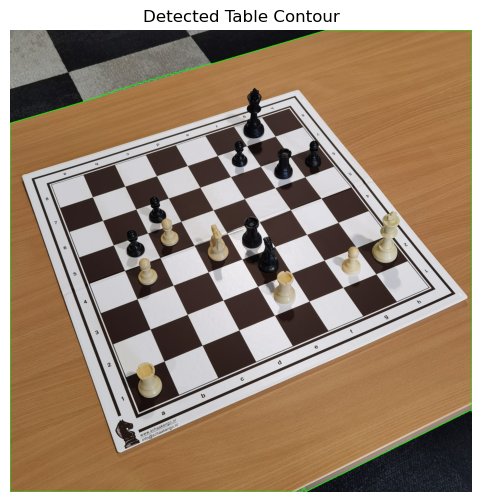

In [6]:
image = cv2.imread(image_paths[0])

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower_brown = np.array([10, 30, 100])
upper_brown = np.array([30, 255, 255])

mask = cv2.inRange(hsv, lower_brown, upper_brown)

kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

table_contour = max(contours, key=cv2.contourArea)

contour_image = image.copy()
cv2.drawContours(contour_image, [table_contour], -1, (0, 255, 0), 3)

contour_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.title("Detected Table Contour")
plt.imshow(contour_rgb)
plt.axis('off')
plt.show()


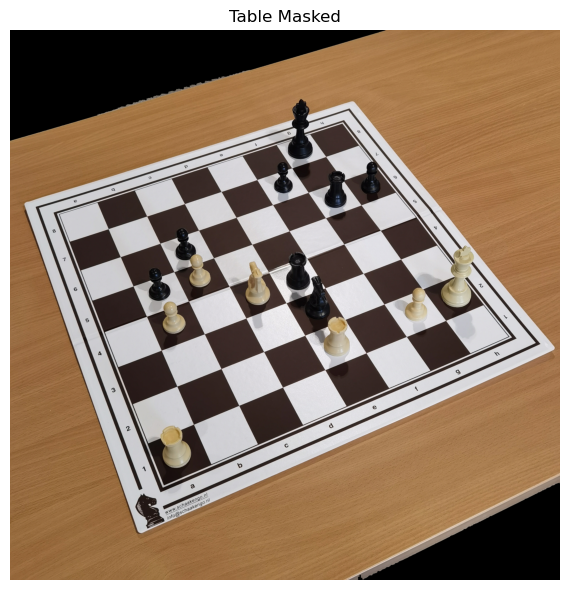

In [8]:
table_mask = np.zeros_like(image)
cv2.drawContours(table_mask, [table_contour], -1, (255, 255, 255), thickness=cv2.FILLED)
masked_image = cv2.bitwise_and(image, table_mask)

masked_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)

# Display both results side-by-side
plt.figure(figsize=(12, 6))

plt.plot(1, 2, 2)
plt.title("Table Masked")
plt.imshow(masked_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()


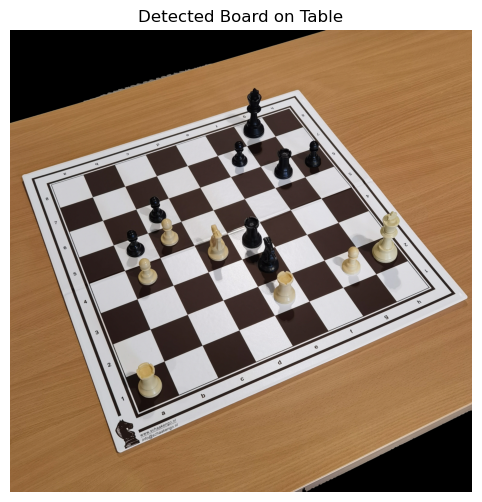

In [ ]:
# Create a black mask
board_mask = np.zeros_like(image)

# Draw only the board contour in white
if board_contour is not None:
    cv2.drawContours(board_mask, [board_contour], -1, (255, 255, 255), thickness=cv2.FILLED)
else:
    print("No board contour found.")

# Apply the board mask to original image
board_only = cv2.bitwise_and(image, board_mask)

# Display result
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.title("Isolated Board Only (Table Removed)")
plt.imshow(cv2.cvtColor(board_only, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


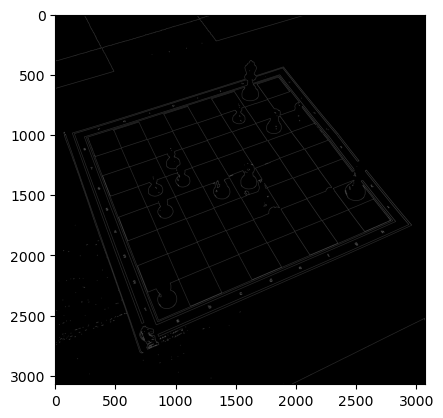

In [11]:
canny = cv2.Canny(otsu_binary,20,255)

plt.imshow(canny,cmap="gray")

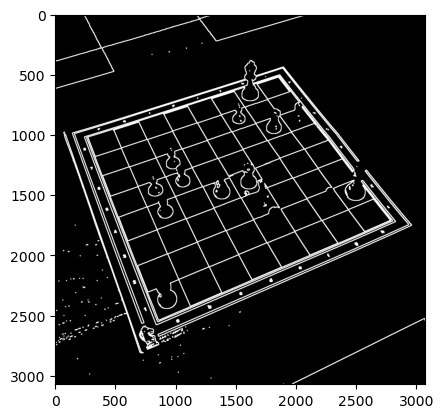

In [12]:
kernel = np.ones((7, 7), np.uint8) 
  
img_dilation = cv2.dilate(canny, kernel, iterations=1) 

plt.imshow(img_dilation,cmap="gray")

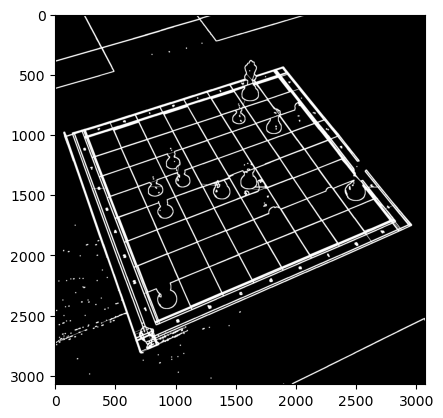

In [13]:
lines = cv2.HoughLinesP(img_dilation, 1, np.pi/180, threshold=200, minLineLength=100, maxLineGap=50)

if lines is not None:
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        
        # draw lines
        cv2.line(img_dilation, (x1, y1), (x2, y2), (255,255,255), 2)

plt.imshow(img_dilation,cmap="gray")

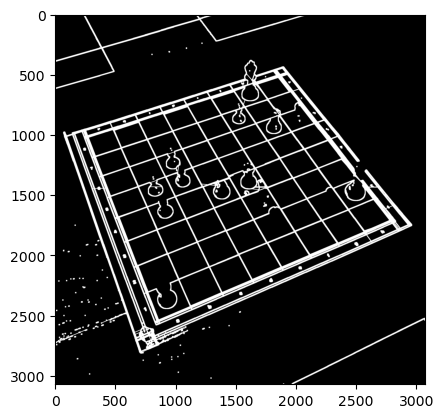

In [14]:
kernel = np.ones((3, 3), np.uint8) 
  
img_dilation_2 = cv2.dilate(img_dilation, kernel, iterations=1) 

plt.imshow(img_dilation_2,cmap="gray")

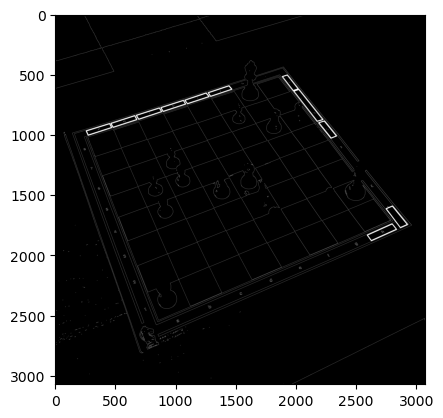

ModuleNotFoundError: No module named 'chessboard_segmentation'